# Week 2 Notebook – Predicting Early Mortgage Delinquency

## Peer Review Note

Hi peers,

This notebook walks through my Week 2 exploration of the Home Credit dataset as part of my capstone project on predicting early mortgage delinquency.

My approach includes:
- **Exploratory Data Analysis (EDA):** I examined distributions, class imbalance, and engineered a new feature (INCOME_CREDIT_RATIO) to capture borrower leverage.
- **Multicollinearity Check:** I used Variance Inflation Factor (VIF) to detect and address feature redundancy. Based on high VIF values, I dropped AMT_GOODS_PRICE.
- **Leakage Check:** I scanned for post-loan features that could bias the model and retained only application-time variables.
- **Modeling:** I applied Lasso, Ridge, and Elastic Net regression using cross-validation. All models were evaluated using R² and RMSE.

### Key Insight:
The models produced low R² scores (~0.006), indicating weak linear relationships in the current feature set. While performance was limited, this regression work establishes a baseline and confirms the need for nonlinear modeling and classification methods in the next phase.

**Dataset:** [Home Credit Default Risk Dataset on Kaggle](https://www.kaggle.com/competitions/home-credit-default-risk/data)

I welcome any feedback on:
- Feature engineering opportunities
- Ways to improve EDA flow or visuals
- Alternative regularization/tuning suggestions
- Any other suggestions/ideas

Thanks in advance for your review!




# 2.2 Activity: Week 2 Jupyter Notebook – Linear Regression 2

Assignment: 
Week 2 Jupyter Notebook — Linear Regression 2
Each week, you will apply the concepts of that week to your Integrated Capstone Project’s dataset. In preparation for Milestone One, create a Jupyter Notebook (similar to in Module B, semester two) that illustrates these lessons. There are no specific questions to answer in your Jupyter Notebook files in this course; your general goal is to analyze your data, using the methods you have learned about in this course and in this program, and draw interesting conclusions. 

For Week 2, include concepts such as linear regression with lasso, ridge, and elastic net regression. This homework will be submitted for peer review and feedback in Week 3 in the assignment titled 3.4 Peer Review: Week 2 Jupyter Notebook.

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np




In [136]:
df = pd.read_csv("application_train.csv")

In [137]:
#structure
#review top 5 rows
df.head()



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [138]:
#review number of rows and columns
df.shape

(307511, 122)

In [139]:
df.describe

<bound method NDFrame.describe of         SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0      

/var/folders/2q/3t5h8lp97hz63t941xlydf4w0000gn/T/ipykernel_77202/2148702148.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_pct.values, y=missing_pct.index, palette="coolwarm")


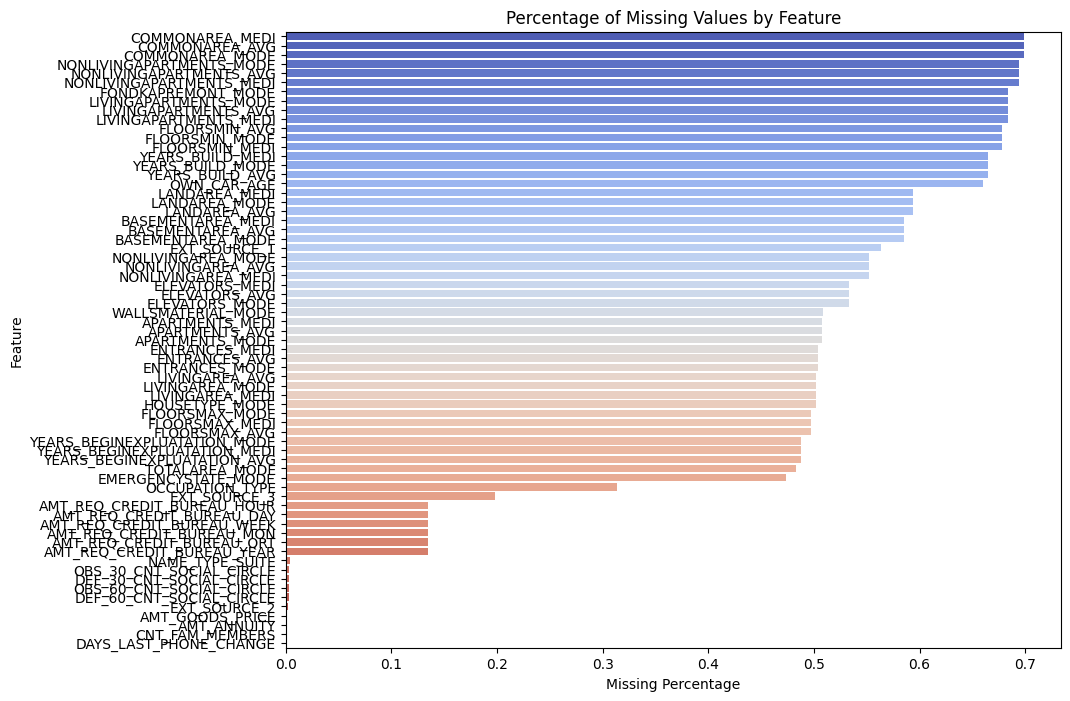

In [140]:
#calc % missing for each column
missing_pct = df.isnull().mean().sort_values(ascending=False)

#filter to columns with missing data
missing_pct = missing_pct[missing_pct > 0]

plt.figure(figsize=(10, 8))
sns.barplot(x=missing_pct.values, y=missing_pct.index, palette="coolwarm")
plt.title("Percentage of Missing Values by Feature")
plt.xlabel("Missing Percentage")
plt.ylabel("Feature")
plt.show()

In [141]:
#class imbalance review 
#if more than ~80% of cases are one class, may need to review sampling  
default_counts = df['TARGET'].value_counts()
default_percent = df['TARGET'].value_counts(normalize=True) * 100

print("Default counts:\n", default_counts)
print("\nDefault percentages:\n", default_percent)


Default counts:
 TARGET
0    282686
1     24825
Name: count, dtype: int64

Default percentages:
 TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64


Analysis of default count --

- 91.9% of applicants did not default
- Only 8.1% of applicants did default
- This is a highly imbalanced dataset. This should be OK since it is common in credit risk modeling -- most applicants do not default. We will need to adjust for imbalance.

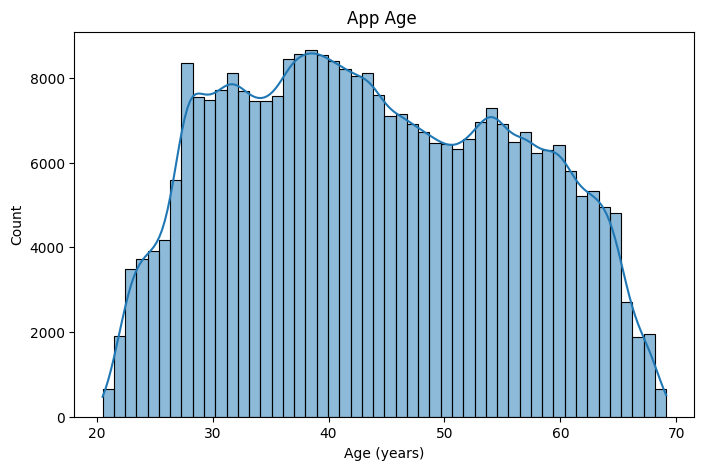

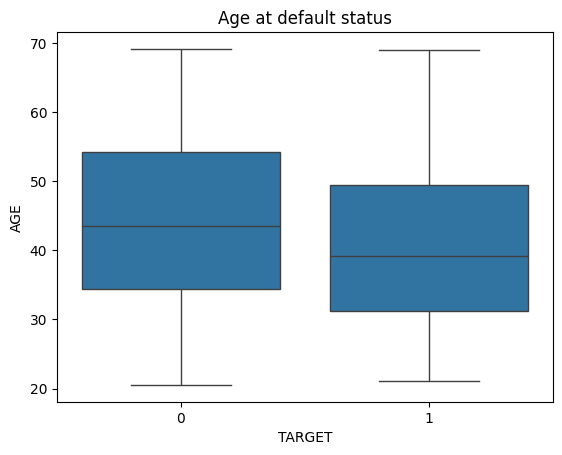

In [142]:
#convert DAYS_BIRTH to age in years
# needed to convert to age because of how the data was structured in the file.
# the raw variable DAYS_BIRTH represented a negative number of days before the loan application, such as -12,000 days.
df['AGE'] = (-df['DAYS_BIRTH']) / 365

plt.figure(figsize=(8, 5))
sns.histplot(df['AGE'], bins=50, kde=True)
plt.title("App Age ")
plt.xlabel("Age (years)")
plt.show()

sns.boxplot(x='TARGET', y='AGE', data=df)
plt.title("Age at default status")
plt.show()



Analysis of plts -- 
1. Histogram / age 
	- Most applicants are between 25 and 60 years old.
	- There's a peak in the 30s and 40s, with a gradual decline afterward.
	- very few applicants are over 65 or under 25.
    - supports that the dataset covers working-age adults -- which makes sense for loan applications.

2. Boxplot /  age vs default Status
	- Apps who defaulted (TARGET = 1) have a slightly lower median age than those who repaid.
	- The interquartile range (middle 50%) of defaulters is slightly lower than non-defaulters.
	- Both groups span a similar full range (roughly 20–70), but defaulters skew younger.
    -  borrowers are slightly more likely to default, suggesting that age may be a useful predictive feature.


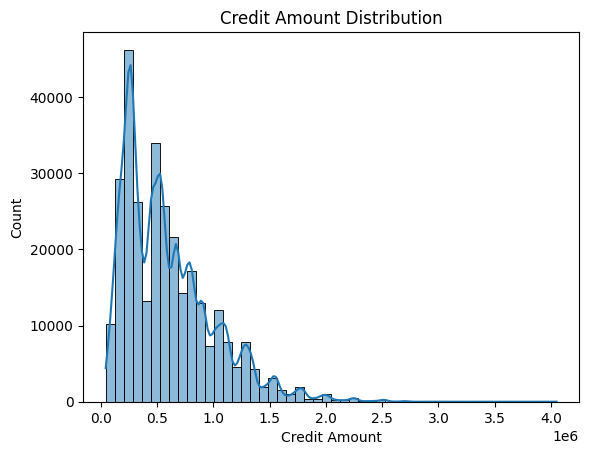

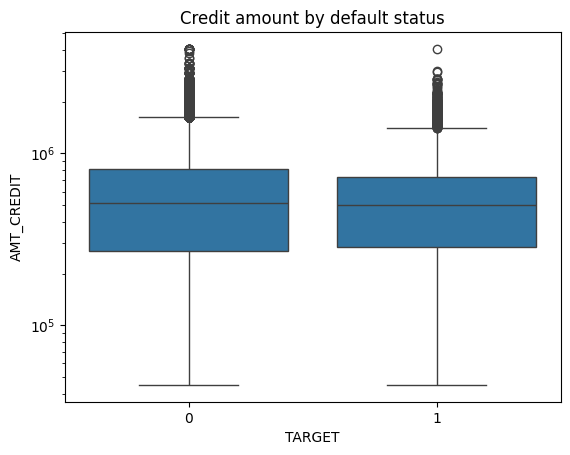

In [143]:
#analyze credit amount 
#help flag risk factors and outliers tied to borrower age, loan size, etc.
sns.histplot(df['AMT_CREDIT'], bins=50, kde=True)
plt.title("Credit Amount Distribution")
plt.xlabel("Credit Amount")
plt.show()

sns.boxplot(x='TARGET', y='AMT_CREDIT', data=df)
plt.yscale('log')
plt.title("Credit amount by default status")
plt.show()


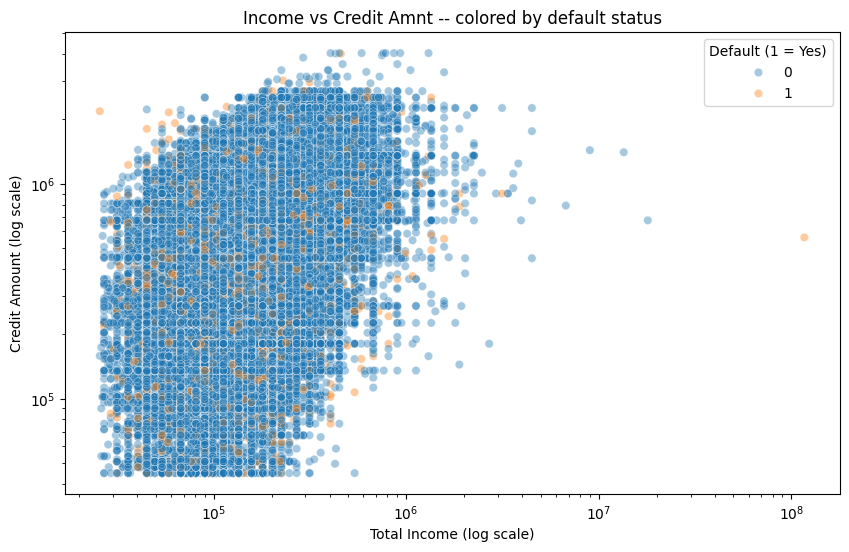

In [144]:
#income vs. credit amount by defalt 
#view relationship between total income and credit amount 
# and how that relationship differs between defaulters and non-defaulters
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df,
    x='AMT_INCOME_TOTAL',
    y='AMT_CREDIT',
    hue='TARGET',
    alpha=0.4
)

plt.xscale('log')
plt.yscale('log')
plt.title("Income vs Credit Amnt -- colored by default status")
plt.xlabel("Total Income (log scale)")
plt.ylabel("Credit Amount (log scale)")
plt.legend(title='Default (1 = Yes)')
plt.show()


Analysis of plot above -- Income vs Credit Amnt -- colored by default

1.most appls have income between $50,000 -- $5000,000, and credit amount between $100,000 -- $1,000,000

Majority of points are blue (TARGET = 0 = non-default), which is expected given the earlier imbalance (only ~8% defaulted which aligns with our previous findings).

Orange points (TARGET = 1 = default) appear more frequently in the lower-income / high-credit region, suggesting some highher risk.

Due to this, I will create a plot showiung the income to credit ratio below. The idea is that a low ratio of income to credit may mean that someone is overleveraged. 


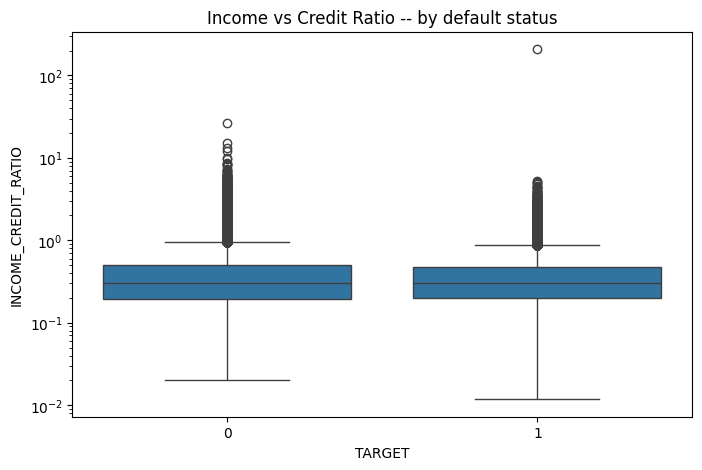

In [145]:
#income to credit amount plot
df['INCOME_CREDIT_RATIO'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
plt.figure(figsize=(8, 5))
sns.boxplot(x='TARGET', y='INCOME_CREDIT_RATIO', data=df)
plt.yscale('log')
plt.title("Income vs Credit Ratio -- by default status")
plt.show()


Analysis if plot above -- Income vs Credit Ratio -- by default status


- Both groups (default = 1, non-default = 0) have a similar median ratio.
- defaulters (TARGET = 1) show slightly lower typical ratios on average and tighter interquartile range (middle 50%)
- a few outliers existr in both groups, but not many.

In [146]:
#Data leakage check
#performed a keyword-based scan for common leakage indicators such as "PAYMENT", "DRAWING", "LATE", "OVERDUE", "DAYS_LAST", and "CNT_PAYMENT".
leakage_keywords = ['PAYMENT', 'DRAWING', 'LATE', 'OVERDUE', 'DAYS_LAST', 'CNT_PAYMENT']
suspicious_cols = [col for col in df.columns if any(k in col.upper() for k in leakage_keywords)]
print("Possible leakage-related columns:")
print(suspicious_cols)


Possible leakage-related columns:
['DAYS_LAST_PHONE_CHANGE']


Anaylsis and outcome of the data leak check 

The only feature flagged was 	DAYS_LAST_PHONE_CHANGE: This represents the number of days since the borrower last changed their phone number. Although it's included in the application data and likely available at loan approval, it could be subject to updates post-application in some operational systems.

I did not remove DAYS_LAST_PHONE_CHANGE for now, as it does not clearly represent post-loan behavior. Can monitor during model evaluation to ensure it does not influence performance in a skewed way.
No other known leakage-prone fields (e.g., actual payment amounts, credit usage behavior) were present in the dataset at this stage.

In [147]:
#CALC VIF
#select numerical features that are probably relevant and numerical (not category)
features_for_vif = [
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'AMT_GOODS_PRICE',
    'AGE',  # previously engineered from DAYS_BIRTH
    'INCOME_CREDIT_RATIO'  # engineered feature
]

#drop rows with missing values in these columns
df_vif = df[features_for_vif].dropna()

In [148]:
#scale data 
scaler = StandardScaler()
X_vif_scaled = scaler.fit_transform(df_vif)

In [149]:
#create VIF dataframe
vif_df = pd.DataFrame()
vif_df["Feature"] = df_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif_scaled, i) for i in range(X_vif_scaled.shape[1])]

#sort
vif_df.sort_values("VIF", ascending=False)

,Feature,VIF
1,AMT_CREDIT,40.225996
3,AMT_GOODS_PRICE,39.685118
5,INCOME_CREDIT_RATIO,4.696424
0,AMT_INCOME_TOTAL,4.279054
2,AMT_ANNUITY,2.649128
4,AGE,1.013134


### Multicollinearity Check (VIF)

I calculated the Variance Inflation Factor (VIF) for a subset of key numerical features. Two features AMT_CREDIT and AMT_GOODS_PRICE, which showed VIFs over 39, indicating strong multicollinearity.

I dropped AMT_GOODS_PRICE and retained AMT_CREDIT as it more accurately reflects the actual loan size. See cleaned set below.

All remaining features have VIF < 5, suggesting acceptable multicollinearity levels for linear modeling.

In [150]:
# set the cleaned list of features 
features_for_modeling = [
    'AMT_INCOME_TOTAL',
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'AGE',
    'INCOME_CREDIT_RATIO'
]

# create df, drop rows with missing values
df_vif = df[features_for_modeling].dropna()

#standardize the features 
scaler = StandardScaler()
X_vif_scaled = scaler.fit_transform(df_vif)

#calc VIF for each feature
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif_df = pd.DataFrame()
vif_df["Feature"] = df_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_vif_scaled, i) for i in range(X_vif_scaled.shape[1])]

#sorted results
vif_df.sort_values("VIF", ascending=False)


,Feature,VIF
4,INCOME_CREDIT_RATIO,4.673061
0,AMT_INCOME_TOTAL,4.266343
1,AMT_CREDIT,3.130202
2,AMT_ANNUITY,2.586815
3,AGE,1.013022


### VIF  on cleaned feature set

After identifying strong multicollinearity between AMT_CREDIT and AMT_GOODS_PRICE, I removed AMT_GOODS_PRICE and recalculated VIF.

The final selected features include:
- AMT_INCOME_TOTAL
- AMT_CREDIT
- AMT_ANNUITY
- AGE
- INCOME_CREDIT_RATIO

All VIF scores were under 10, suggesting acceptable multicollinearity levels for linear regression modeling.


### Feature Engineering

During EDA, I created a new feature to reflect borrower leverage:

- INCOME_CREDIT_RATIO = AMT_INCOME_TOTAL / AMT_CREDIT

This ratio captures a borrower’s income relative to their requested loan amount, acting as a proxy for repayment capacity. It passed multicollinearity checks and was retained as part of the final feature set used for modeling.



### Next step >>  Create modeling pipeline using Lasso Regression (LassoCV), Ridge Regression (RidgeCV), Elastic Net (ElasticNetCV)


In [151]:
##PREP DATA
#using final/clean dataset with selected features and no missing values
model_df = df[features_for_modeling + ['TARGET']].dropna()
X = model_df[features_for_modeling]
y = model_df['TARGET']

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##FIT LASSO MODEL
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train_scaled, y_train)
lasso_preds = lasso.predict(X_test_scaled)


#FIT RIDGE MODEL
ridge = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5)
ridge.fit(X_train_scaled, y_train)
ridge_preds = ridge.predict(X_test_scaled)


##FIT ELASTIC NET MODEL 
elastic = ElasticNetCV(cv=5, random_state=42)
elastic.fit(X_train_scaled, y_train)
elastic_preds = elastic.predict(X_test_scaled)


##EVAL MODELS
def evaluate(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    print(f"{model_name} | R^2: {r2:.4f} | RMSE: {rmse:.4f}")

evaluate(y_test, lasso_preds, "Lasso")
evaluate(y_test, ridge_preds, "Ridge")
evaluate(y_test, elastic_preds, "Elastic Net")

Lasso | R^2: 0.0060 | RMSE: 0.2716
Ridge | R^2: 0.0061 | RMSE: 0.2716
Elastic Net | R^2: 0.0060 | RMSE: 0.2716


### Model Performance Summary

| Model       | R²     | RMSE   | Notes                                               |
|-------------|--------|--------|-----------------------------------------------------|
| Lasso       | 0.0060 | 0.2716 | R² is extremely low — the model explains almost no variance |
| Ridge       | 0.0061 | 0.2716 | Nearly identical — very limited predictive power     |
| Elastic Net | 0.0060 | 0.2716 | Same story — reinforces the weak linear relationship |


The regularized linear models are barely outperforming a flat line; R² values this low indicate almost no explanatory strength.
An RMSE of ~0.27, given a binary (0/1) outcome, suggests the models are mostly predicting the average of the target rather than capturing any real signal.
The linear relationships between these features and early delinquency are weak. This could mean:
- The current features just aren’t strong predictors
- The signal might be nonlinear or based on interactions
- The target definition could use refinement, for example, narrowing in on 30–60 day delinquencies instead of lumping all defaults together


### Model Performance / Analysis

I ran Lasso, Ridge, and Elastic Net regressions using a cleaned set of features with low multicollinearity. All three models returned very low R² values (around 0.006) and an RMSE of about 0.271.
This suggests that the selected features within a linear framework don’t offer much predictive value for the target:

-  There doesn’t seem to be a strong linear relationship between the predictors and early delinquency
- Nonlinear models or interactions might be necessary to capture more signal
- Since the target is binary, a classification approach could be a better fit overall


These results give me a good baseline to compare against more complex models later on.

## Summary & Next Steps 

This Week 2 notebook focused on building a foundational understanding of the Home Credit dataset and applying regularized regression techniques (Lasso, Ridge, Elastic Net) to establish a baseline.

### Accomplishments / Completed
- Explored the data: looked at distributions, class imbalance, and some feature relationships  
- Created a new feature, INCOME_CREDIT_RATIO, to capture borrower leverage  
- Handled multicollinearity by checking VIF and dropping highly correlated features  
- Trained and evaluated three regularized linear models using cross-validation

### Main Takeaway
The R² scores were very low (around 0.006), which suggests that the features used don’t have strong linear relationships with the target. So, this really confirmed the need to shift toward non-linear models and treat this as a classification problem instead.

### Next Up
- Reframe the problem as binary classification  
- Try logistic regression and tree-based models like Random Forest and XGBoost  
- Use oversampling (like SMOTE) to help with the class imbalance  
- Add and test more engineered features and interactions

This sets me up with a solid base for Milestone 1. I’d love any feedback, especially on feature engineering ideas or model setup improvements!